In [1]:
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wandb
import optuna
# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify,poly
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')
from statistics import mean
import datetime
import time
datetime.datetime.now()

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdexper as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

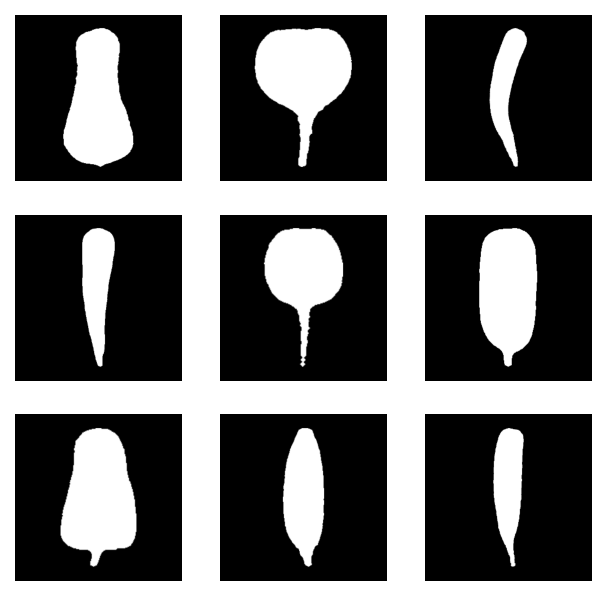

In [2]:
NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
#imgs = collectimages(NSilF)       # シルエット画像のリスト
plt.figure(figsize=(5,5),dpi=150)
for i in range(9):
  rd.plotimg(imgs[i],330+i+1)
  #plotimg(imgs[i],330+i+1)

In [3]:
import time

def meanerr(func, ts, Samples):
  sps = Samples
  fx, fy = func
  t = symbols('t')
  nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
  onps = [[nfx(ts[i]), nfy(ts[i])] for i in range(len(ts))]
  return mean([np.sqrt((sps[i][0]-onps[i][0])**2+(sps[i][1]-onps[i][1])**2) for i in range(len(sps))])

def check0N(imgnum,Nsamples=65,Nfrom=5,Nto=20,err_th=0.65,withFig=True):
    results = {}
    for N in range(Nfrom,Nto+1):
      print(N,end='')
      start = time.process_time()
      img = imgs[imgnum]
      conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
      Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
      bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
      cps, func = bez.fit0(tpara=[])
      etime = time.process_time() - start
      odds = rd.isOverFitting(func,bez.ts,conAll)
      err = meanerr(func,bez.ts,Samples)
      results[str(N)] = (odds,err,etime)
      if err < err_th:
        break
    print("\nN= {}  err = {}   etime = {}".format(N,err,etime))
    if withFig:
      rd.drawBez(imgs[imgnum],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return results

In [4]:
#実輪郭の標本点間の輪郭長と近似曲線の対応区間長との差の分布において、４分位範囲の１．５倍基準の両方ではずれ値と判定される区間を含む場合にオーバフィッティングと判定する。
def isOverFitting2(func,ts,cont,of_th=0.5):
    if len(cont) == 0:
        return []
    Nsamples = len(ts)
    # 実輪郭線側の標本点間弧長を計算する
    axlength = np.array(cv2.arcLength(cont,closed=False))  # 全周の長さ
    span = axlength/(Nsamples-1)
    lengths = np.array([cv2.arcLength(cont[:i+1], closed=False) for i in range(len(cont))])
                                                    # 始点から全輪郭点にいたる弧長
    spidx = np.array([np.abs(lengths - i).argmin() for i in np.linspace(0, axlength, Nsamples)])
                                                    # 等間隔にとった標本点のインデックス
    rs1 = []
    for i in range(Nsamples-1):
        qls = np.linspace(lengths[spidx[i]],lengths[spidx[i+1]],5)
        qidx = np.array([np.abs(lengths - l).argmin() for l in qls])
        rq5 = np.array([cont[s] for s in qidx]) 
        rs1.append(rq5) # 各区分の両端と4分割点計5点ずつのリスト
    # 近似曲線側の弧長を計算する
    rs2 = []
    fx,fy = func
    nfx, nfy = lambdify('t', fx, "numpy"), lambdify('t', fy, "numpy")
    for i in range(Nsamples-1):
        d5 = rd.getDenseParameters(func, st=ts[i], et=ts[i+1], n_samples=5) # 標本点のパラメタ間を4分割
        aq5 = np.array([[nfx(s),nfy(s)] for s in d5]) # 近似曲線上で区間を4等分する座標のリスト
        rs2.append(aq5)
    # 
    difs = np.array([np.std(np.sum((rq5-aq5)*(rq5-aq5),axis=1)) for (rq5,aq5) in zip(rs1,rs2)])
    q75, q25 = np.percentile(difs, [75,25]) # 四分位点
    odds0 = np.where((difs>q75+1.5*(q75-q25))) # 異常値のインデックス
    odds = np.where(difs > of_th*span)[0] # 
    print(odds,[difs[i] for i in odds0])
    return odds # 

In [36]:
def testOF(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,mode=1,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit1T(tpara=[],mode=mode,err_th=err_th,lr=lr,lrP=lrP,pat=pat,withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return err,isOverFitting2(func,bez.ts,conAll,of_th=of_th)

def testOF1(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit1(tpara=[],err_th=err_th,pat=pat,withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return err,isOverFitting(func,bez.ts,conAll,of_th=of_th)

^^^^^^^^^^^^^^^
CP 5.0, steps:14, etime: 10.09375 err: 4.7102547081
^.^^.^.....^.....................
CP 2.0, steps:47, etime: 21.14062 err: 1.9934006401
...................^^^..^^^^^^^....................^
^^..^^^^^^^....................^^^^..^^^^.^^^^^^^.^.^...........^^^^^..^^^..^..............^^^^^.^^^
^^^^^..^^...^......E

[] [array([2.19933168, 2.13200713, 3.80335013])]


(0.999650046406839, array([], dtype=int64))

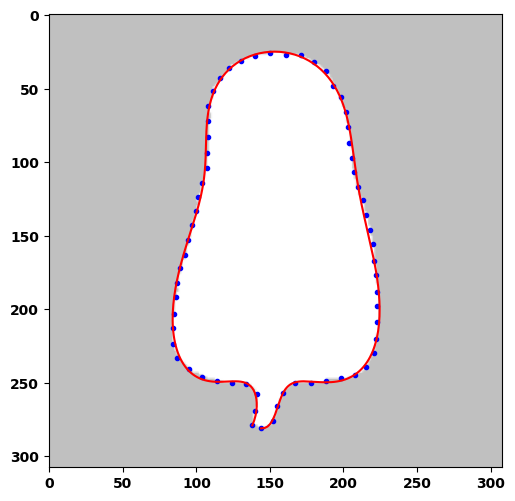

In [34]:
testOF(imgn=6,N=14,mode=0,err_th=1)

^^^^^^^.^.^.^..
CP 5.0, steps:14, etime: 3.54688 err: 4.5679356486
.....
CP 2.0, steps:19, etime: 4.14062 err: 1.6232158622
^..^..^..^^..^................................................................^^
^^^^^^^^^^^^^........................................^^^^^^^^^^^^^^^^^^......................E

[] [array([2.87096966, 2.08382473, 2.2637717 , 2.82671291])]


(0.9993519811648999, array([], dtype=int64))

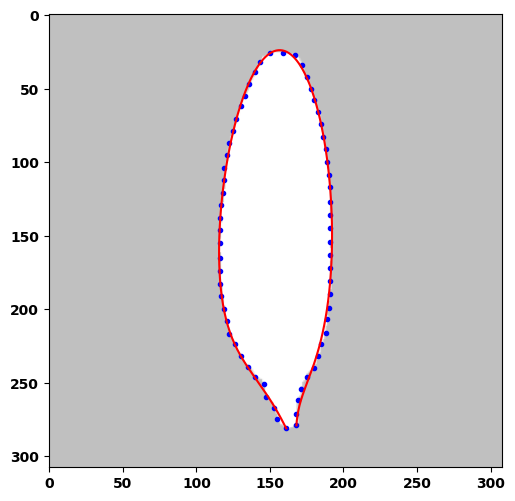

In [33]:
testOF(imgn=7,N=6,mode=0,err_th=1)

................
CP 5.0, steps:15, etime: 20.31250 err: 4.8939381189
....................................................................................
..............
CP 2.0, steps:113, etime: 119.87500 err: 1.9902368748
......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^^^^...^^^.............^.^..........................
..........^.^.^...^.^..^..^..^..........^..^..^..^.^^^^^^^^^^^^.............^..^..^..^..^...^^^^.^^.
^^...................^^.....^..^^..^.^^...^......^...^^^^^^^^^^^^^^^^^^^^.^^^..^^..^

(0.9999120460187123, array([62, 63], dtype=int64))

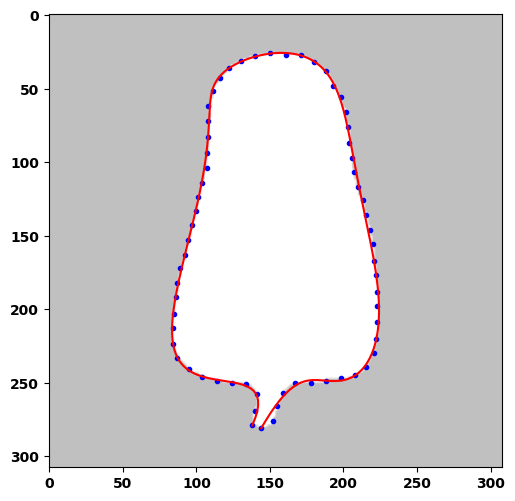

In [31]:
testOF(imgn=6,N=10,mode=1,err_th=1)

................
CP 5.0, steps:15, etime: 20.68750 err: 4.8939381189
....................................................................................
..............
CP 2.0, steps:113, etime: 122.14062 err: 1.9902368748
......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^^^^...^^^.............^.^..........................
..........^.^.^...^.^..^..^..^..........^..^..^..^.^^^^^^^^^^^^.............^..^..^..^..^...^^^^.^^.
^^...................^^.....^..^^..^.^^...^......^...^^^^^^^^^^^^^^^^^^^^.^^^..^^..^

(1.0133036766732675, array([63], dtype=int64))

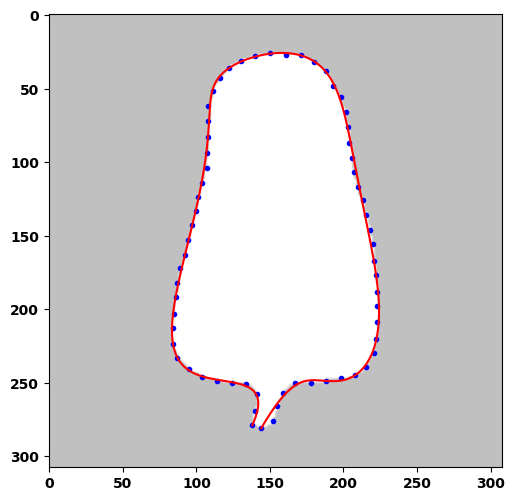

In [39]:
testOF(imgn=6,N=10,mode=1,err_th=0.65)

...
CP 5.0, steps:2, etime: 6.56250 err: 4.8923418547
..................................
CP 2.0, steps:36, etime: 34.12500 err: 1.9823473007
...............................................................
....................................................................................................
..................
CP 1.0, steps:217, etime: 181.51562 err: 0.9992883684
..................................................................................
...........................................................................
CP 0.65, steps:374, etime: 308.96875 err: 0.6488220548
.........................
..........................................................................E



(0.4992479828046801, array([], dtype=int64))

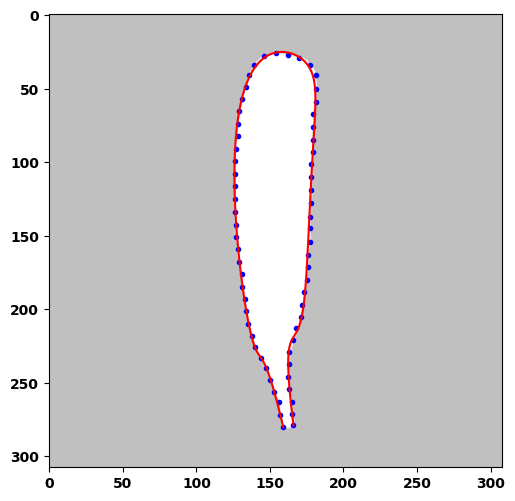

In [24]:
testOF(imgn=8,N=9,mode=1,err_th=0.5)

.............
CP 5.0, steps:12, etime: 11.62500 err: 4.9143288917
...............................
CP 2.0, steps:43, etime: 31.70312 err: 1.9973247076
........................................................
....................................................................................................
^^.^...........................^^.^.^.^.........^^^.^.^........^......................^^^^^^^^.^^..^
............................^^^..^..^.............^^^^^^^.^.....^.^.^..............^^^^^.^.^^..^^...
^.....^^^..^..^^^^^^^..^^^...^^^^^^^.^^.^.^^^^^..^^.....^^.^^^^^.^.^..^.^^.^^^^^^^^^^^.^.^..........
...^^^^^^^^^^..........^^^....^..^...^.^.^^^^^^^^^^^^^^.^^^^.^^^^^^..........^^^^.^^.^.^.^^^^.^^.^..
^.........^^^^^^^^.^.^.^.^^^^^^^^.^.....^......^......^^^^^^^^..^...^^^^^^^.^.^..^.^^.^^^^.^..^..^^^
^..^^^^^^..^^^^.^^.^^..^^^^^.^.^^^^^^^^^.......^...^.^^^^^..^^^^^^^..^^.^^.^....^..^.^^.^^^^^^^^^^.^
^.^^...^^.^^^^^^^^^..^..^^..^^^^^.^...^^^..^^^.^^^^^.............^^^^^^.^^^.^^^^....^.

(0.9947144709202382, array([57], dtype=int64))

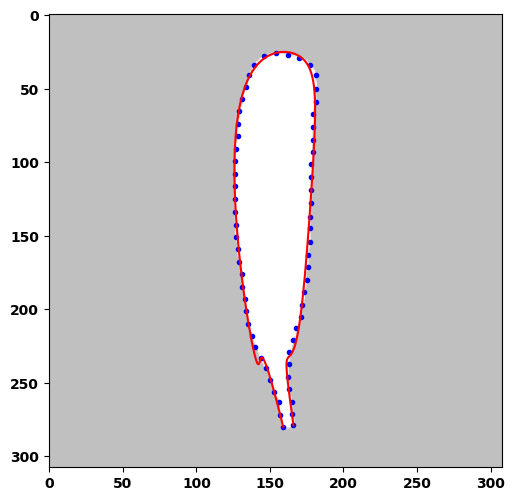

In [37]:
testOF(imgn=8,N=8,mode=1,err_th=1)

....
CP 5.0, steps:3, etime: 4.32812 err: 4.0570447133
...
CP 2.0, steps:6, etime: 5.79688 err: 1.5684979508
....
CP 1.0, steps:10, etime: 7.73438 err: 0.9950934095
.........................................................................................
..............
CP 0.65, steps:113, etime: 57.92188 err: 0.6493082898
......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................^....................................^........................................^^...
...................................^^^.......................................^^.....

(0.49998392725923885, array([], dtype=int64))

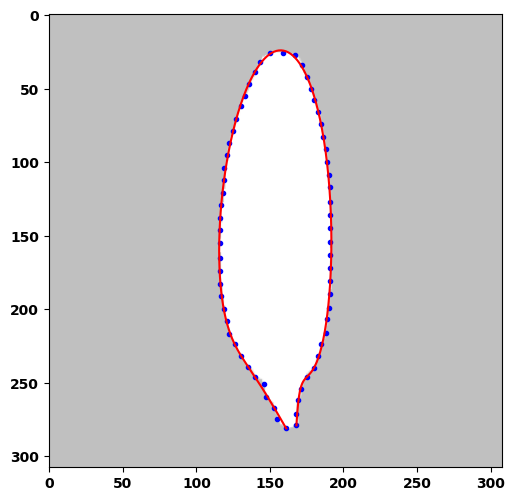

In [22]:
testOF(imgn=7,N=7,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 4.43750 err: 4.0570447133
...
CP 2.0, steps:6, etime: 5.89062 err: 1.5684979508
....
CP 1.0, steps:10, etime: 7.84375 err: 0.9950934095
.........................................................................................
..............
CP 0.65, steps:113, etime: 58.14062 err: 0.6493082898
......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................^....................................^........................................^^...
...................................^^^.......................................^^.....

(0.49998392725923885, array([], dtype=int64))

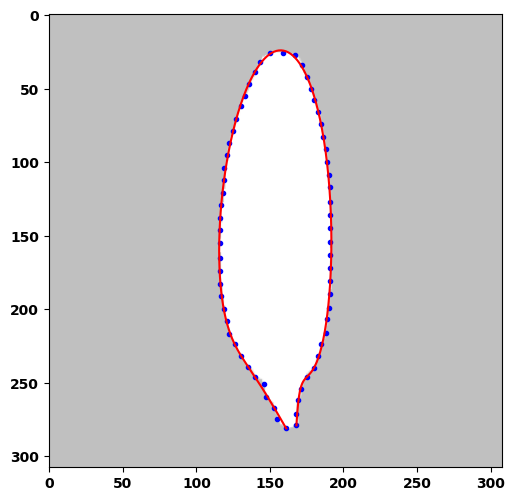

In [21]:
testOF(imgn=7,N=7,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 3.26562 err: 4.3044265142
...
CP 2.0, steps:6, etime: 4.35938 err: 1.8457861020
..........................................................................
CP 1.0, steps:80, etime: 31.10938 err: 0.9997393515
...................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.....................................

(0.6499617296398823, array([], dtype=int64))

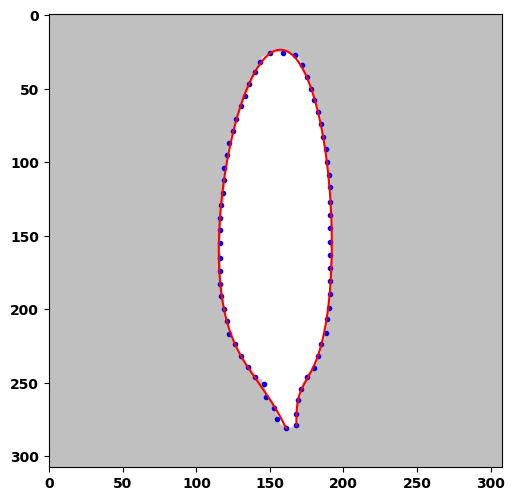

In [20]:
testOF(imgn=7,N=6,mode=1,err_th=0.65)

.
CP 5.0, steps:0, etime: 6.01562 err: 3.5043842213
...........
CP 2.0, steps:11, etime: 21.76562 err: 1.9755567033
...........................
CP 1.0, steps:38, etime: 60.65625 err: 0.9919499326
............................
CP 0.65, steps:66, etime: 100.70312 err: 0.6479381433
.................................
.....................E



(0.4993418145857969, array([], dtype=int64))

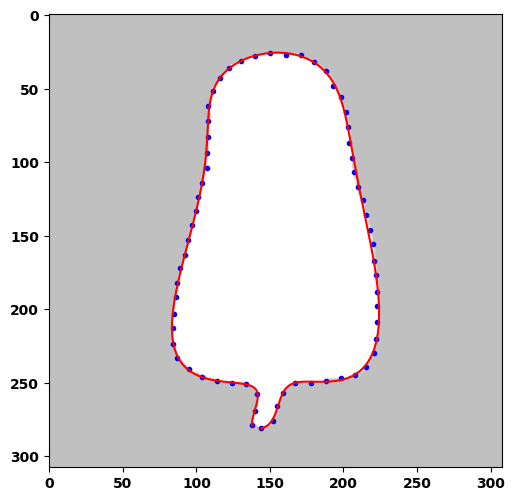

In [19]:
testOF(imgn=6,N=12,mode=1,err_th=0.5)

..
CP 5.0, steps:1, etime: 6.89062 err: 4.9724672526
.................
CP 2.0, steps:18, etime: 27.31250 err: 1.9695702477
.....................................
CP 1.0, steps:55, etime: 72.06250 err: 0.9959101869
............................................
....................................................................................................
.............E



(0.6499797405764021, array([], dtype=int64))

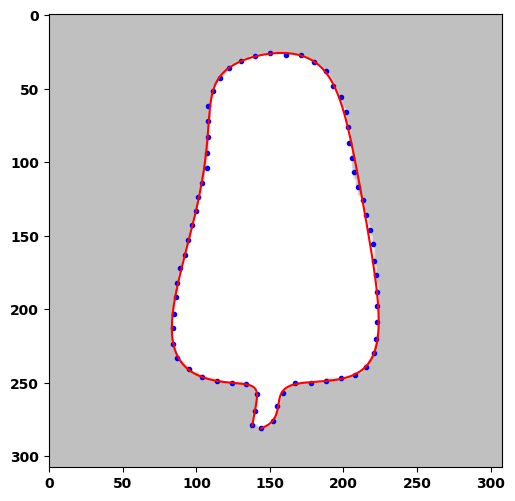

In [18]:
testOF(imgn=6,N=11,mode=1,err_th=0.65)

.
CP 5.0, steps:0, etime: 4.89062 err: 4.5710049162
.................
CP 2.0, steps:17, etime: 19.26562 err: 1.9949542574
..................................................................................
.
CP 1.0, steps:100, etime: 89.64062 err: 0.9944406448
............................................................................
CP 0.65, steps:176, etime: 154.06250 err: 0.6497770160
.......................
..........................................................E

[] [array([3.3680057 , 2.92356743, 2.9543816 ])]


(0.4997608145796149, array([], dtype=int64))

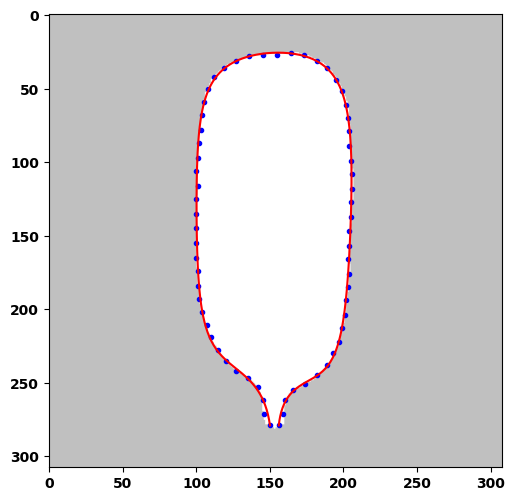

In [41]:
testOF(imgn=5,N=9,mode=1,err_th=0.5)

..........
CP 5.0, steps:9, etime: 9.62500 err: 4.4105466618
................................................................................
CP 2.0, steps:89, etime: 60.43750 err: 1.9946919596
..........
....................................................................................................
..................................................E



(0.9971848174716987, array([], dtype=int64))

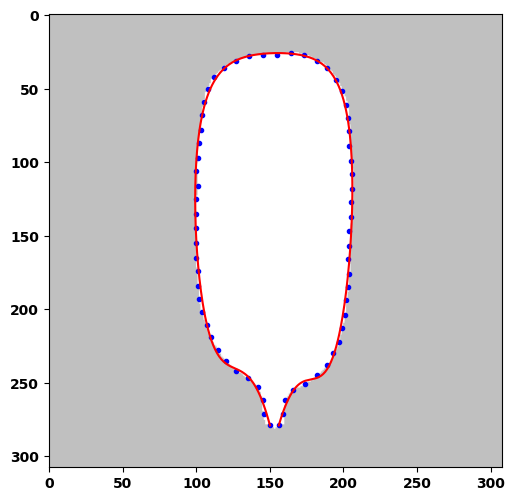

In [16]:
testOF(imgn=5,N=8,mode=1,err_th=1)

HERE

.......
CP 5.0, steps:6, etime: 12.73438 err: 4.9715167777
..........................................
CP 2.0, steps:48, etime: 63.40625 err: 1.9872839437
...................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................................................................................
CP 1.0, steps:497, etime: 604.59375 err: 0.9972565804
..
....................................................................................................
..................................
CP 0.65, steps:633, etime: 768.28125 err: 0.6474517078
..................................................................
...................E



(0.49964983793402257, array([], dtype=int64))

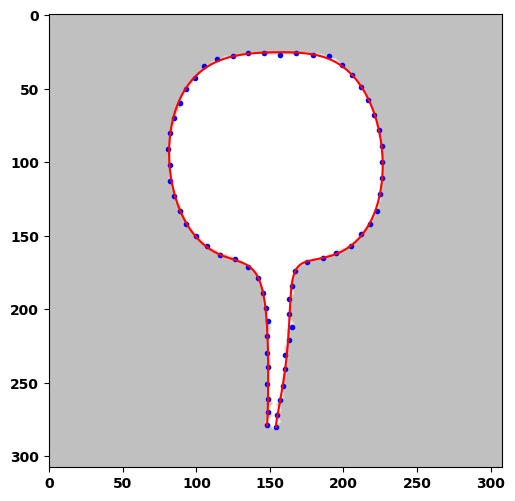

In [15]:
testOF(imgn=4,N=11,mode=1,err_th=0.5)

........
CP 5.0, steps:7, etime: 12.42188 err: 4.9252023902
............................................................................................
.................................
CP 2.0, steps:132, etime: 140.51562 err: 1.9981042466
...................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................
CP 1.0, steps:657, etime: 680.00000 err: 0.9990928137
..........................................
....................................................................................................
..............................

(0.49992409241206204, array([], dtype=int64))

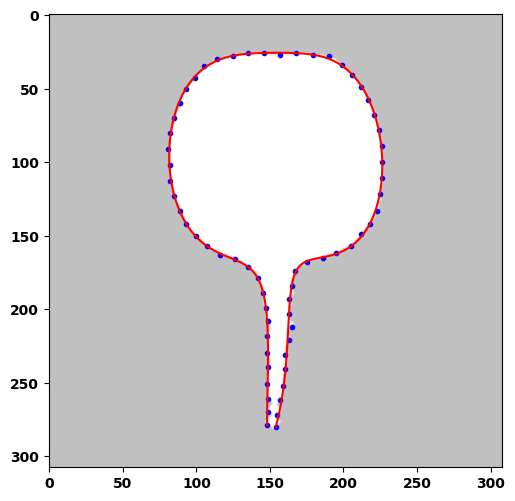

In [13]:
testOF(imgn=4,N=10,mode=1,err_th=0.5)

........
CP 5.0, steps:7, etime: 12.64062 err: 4.9252023902
............................................................................................
.................................
CP 2.0, steps:132, etime: 140.57812 err: 1.9981042466
...................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................
CP 1.0, steps:657, etime: 679.07812 err: 0.9990928137
..........................................
....................................................................................................
..............................

(0.6498885245721306, array([], dtype=int64))

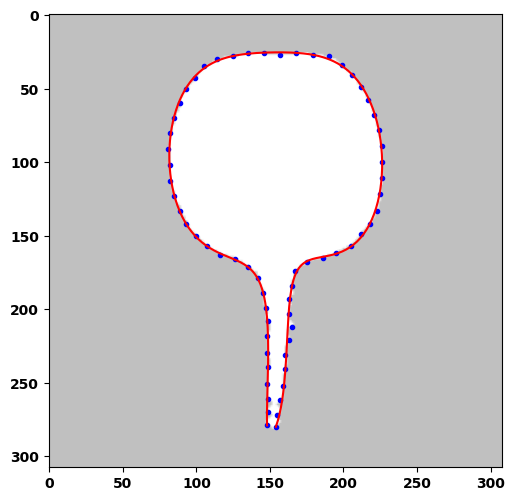

In [14]:
testOF(imgn=4,N=10,mode=1,err_th=0.65)

AVOBE

.............
CP 5.0, steps:12, etime: 12.07812 err: 4.9143288917
...............................
CP 2.0, steps:43, etime: 33.12500 err: 1.9973247076
........................................................
....................................................................................................
^^.^...........................^^.^.^.^.........^^^.^.^........^......................^^^^^^^^.^^..^
............................^^^..^..^.............^^^^^^^.^.....^.^.^..............^^^^^.^.^^..^^...
^.....^^^..^..^^^^^^^..^^^...^^^^^^^.^^.^.^^^^^..^^.....^^.^^^^^.^.^..^.^^.^^^^^^^^^^^.^.^..........
...^^^^^^^^^^..........^^^....^..^...^.^.^^^^^^^^^^^^^^.^^^^.^^^^^^..........^^^^.^^.^.^.^^^^.^^.^..
^.........^^^^^^^^.^.^.^.^^^^^^^^.^.....^......^......^^^^^^^^..^...^^^^^^^.^.^..^.^^.^^^^.^..^..^^^
^..^^^^^^..^^^^.^^.^^..^^^^^.^.^^^^^^^^^.......^...^.^^^^^..^^^^^^^..^^.^^.^....^..^.^^.^^^^^^^^^^.^
^.^^...^^.^^^^^^^^^..^..^^..^^^^^.^...^^^..^^^.^^^^^.............^^^^^^.^^^.^^^^....^.

(0.9947144709202382, array([], dtype=int64))

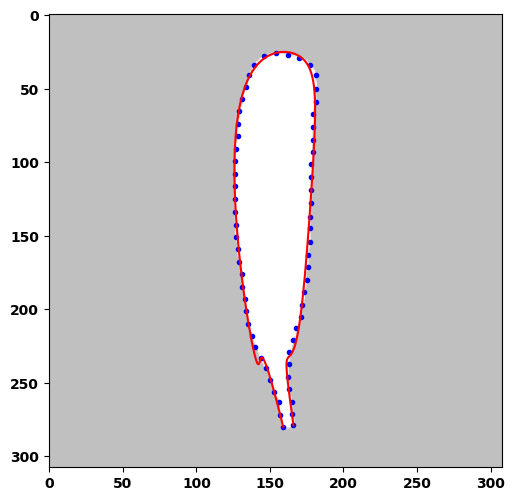

In [26]:
testOF(imgn=7,N=8,mode=0,err_th=1)

.........
CP 5.0, steps:8, etime: 11.53125 err: 4.8344786720
...........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................^.^..^..^.................................^.......................
.^..^^...^^......^......^...^.^^^.^.^.^.^^.^...........^^..^..^......^^^..^^...............^..C



(2.4122512561013196, array([], dtype=int64))

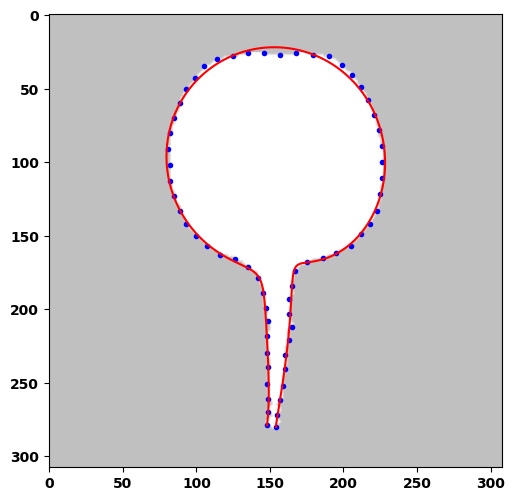

In [12]:
testOF(imgn=4,N=9,mode=1,err_th=1)

........
CP 5.0, steps:7, etime: 12.40625 err: 4.9252023902
............................................................................................
.................................
CP 2.0, steps:132, etime: 140.17188 err: 1.9981042466
...................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................E



(0.9990928136624698, array([], dtype=int64))

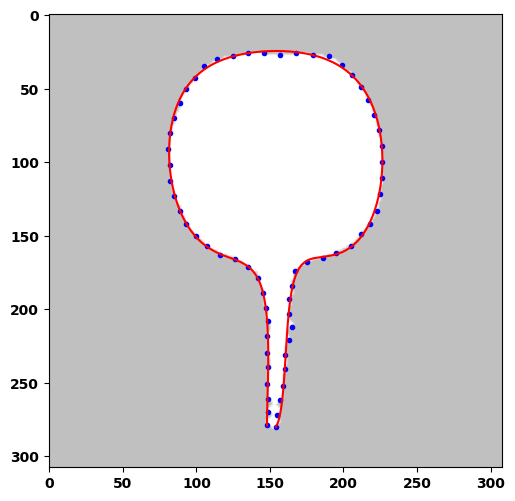

In [11]:
testOF(imgn=4,N=10,mode=1,err_th=1)

....
CP 5.0, steps:3, etime: 8.12500 err: 4.8370081474
.................
CP 2.0, steps:20, etime: 25.07812 err: 1.9785521570
...................
CP 1.0, steps:39, etime: 44.01562 err: 0.9829298367
.................
CP 0.65, steps:56, etime: 61.18750 err: 0.6409405487
.....................E



(0.4986568086756752, array([], dtype=int64))

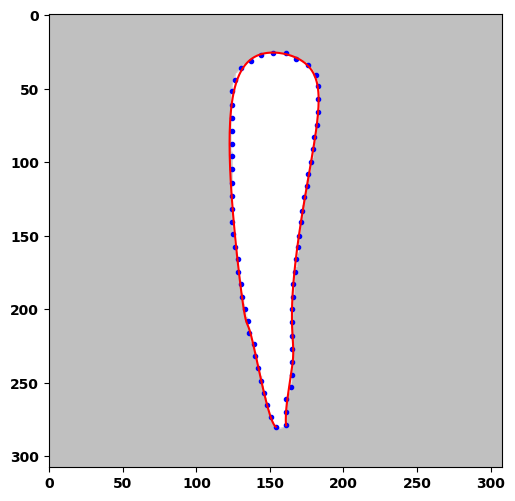

In [10]:
testOF(imgn=3,N=10,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 7.23438 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 38.20312 err: 1.9690211450
....................................................
CP 1.0, steps:93, etime: 80.51562 err: 0.9966282212
......
..............................................................................E



(0.6492956618836446, array([], dtype=int64))

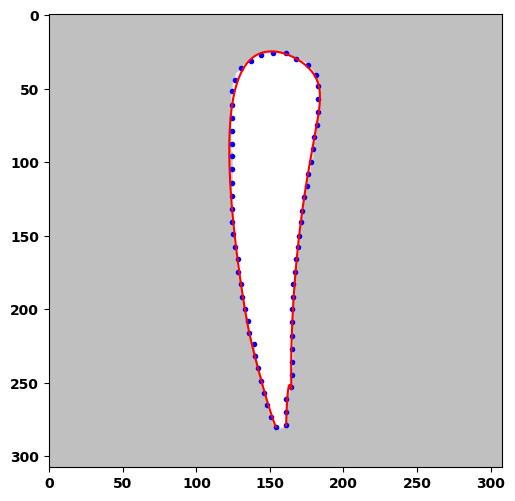

In [9]:
testOF(imgn=3,N=9,mode=1,err_th=0.65)

....
CP 5.0, steps:3, etime: 7.15625 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 38.18750 err: 1.9690211450
....................................................
CP 1.0, steps:93, etime: 80.48438 err: 0.9966282212
......
..............................................................................
CP 0.65, steps:177, etime: 149.64062 err: 0.6492956619
......................
....................................................................................................
......................................................................................^..^.^.^^.^^^^
...^................................^^.................^^^................^.^^^.^^..................
..^^^.^.^.....^^^.^.^.^....^..................^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....
^^..^......^........^^^^^.^.......^.......^....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..^^^..^^^^^^^
^^^.^^........^^^.......^^^^.....^^^..^^.^^^^^.^^.^^..^..^..^...^^..^...^^^^^^..

(0.49990320448514314, array([2], dtype=int64))

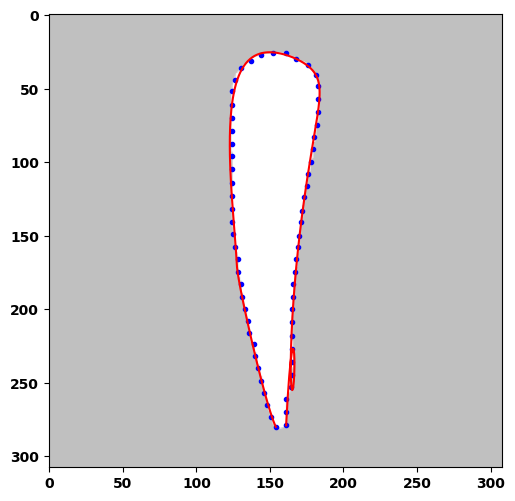

In [7]:
testOF(imgn=3,N=9,mode=1,err_th=0.5)

.....................................E



(0.4964976734959498, array([], dtype=int64))

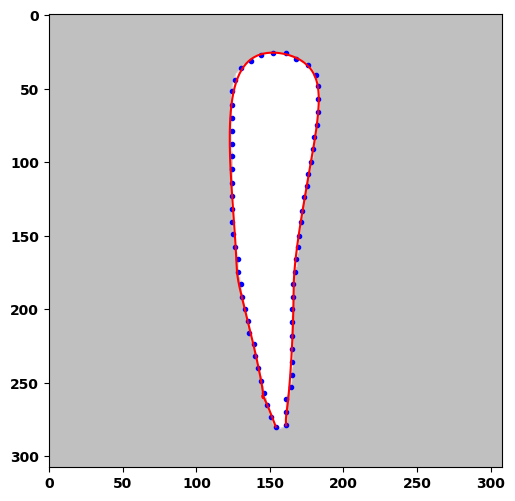

In [7]:
testOF(imgn=3,N=12,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 7.29688 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 38.43750 err: 1.9690211450
....................................................
CP 1.0, steps:93, etime: 81.51562 err: 0.9966282212
......
..............................................................................
CP 0.65, steps:177, etime: 151.40625 err: 0.6492956619
......................
....................................................................................................
......................................................................................^..^.^.^^.^^^^
...^................................^^.................^^^................^.^^^.^^..................
..^^^.^.^.....^^^.^.^.^....^..................^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....
^^..^......^........^^^^^.^.......^.......^....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..^^^..^^^^^^^
^^^.^^........^^^.......^^^^.....^^^..^^.^^^^^.^^.^^..^..^..^...^^..^...^^^^^^..

(0.49990320448514314, array([2], dtype=int64))

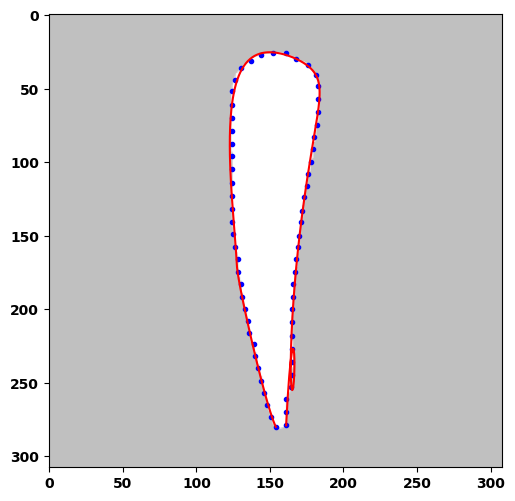

In [15]:
testOF(imgn=3,N=9,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 7.20312 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 38.04688 err: 1.9690211450
....................................................E

[] [array([2.55935656, 3.08687635, 2.06617803, 1.89289845])]


(0.9966282212148804, array([], dtype=int64))

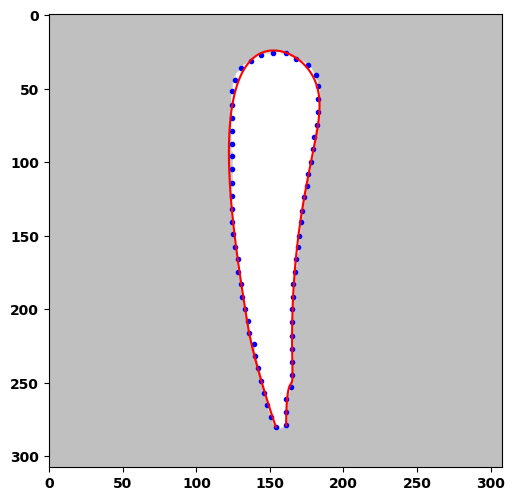

In [14]:
testOF(imgn=3,N=9,mode=1,err_th=1)

..................
CP 5.0, steps:17, etime: 15.23438 err: 4.8426560887
....................
CP 2.0, steps:37, etime: 28.35938 err: 1.9741953111
............................
CP 1.0, steps:65, etime: 46.67188 err: 0.9896702547
..................................
....................................^^..............................^^^.^.^.^.^.....................
..^^^^.^^^..................^^^^^^^.^.^^^^^^..^^^......^^^^^^^^^.^^..^.........^^^^^^^^^^^^^..^.^.^^
^....^.........^^^^^^^^^^^^^^^.^^^^.^^.....^^..^.^^^^^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^.^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^^^^^^^^^^^^^^.^^^^^^^^^^^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.757507535284728, array([57], dtype=int64))

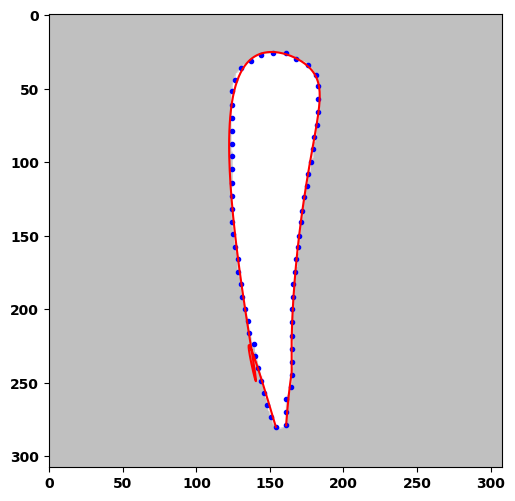

In [13]:
testOF(imgn=3,N=8,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 7.43750 err: 4.3297332264
......................................
CP 2.0, steps:41, etime: 38.65625 err: 1.9690211450
....................................................
CP 1.0, steps:93, etime: 81.67188 err: 0.9966282212
......
..............................................................................
CP 0.65, steps:177, etime: 150.71875 err: 0.6492956619
......................
....................................................................................................
......................................................................................^..^.^.^^.^^^^
...^................................^^.................^^^................^.^^^.^^..................
..^^^.^.^.....^^^.^.^.^....^..................^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....
^^..^......^........^^^^^.^.......^.......^....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..^^^..^^^^^^^
^^^.^^........^^^.......^^^^.....^^^..^^.^^^^^.^^.^^..^..^..^...^^..^...^^^^^^..

(0.49990320448514314, array([2], dtype=int64))

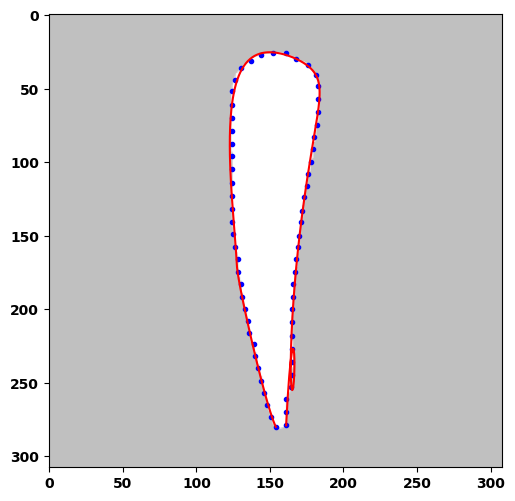

In [12]:
testOF(imgn=3,N=9,mode=1,err_th=0.5)

....................................................................................................
....................................................................................................
........................
CP 5.0, steps:223, etime: 60.07812 err: 4.9843263271
............................................................................
.................................................
CP 2.0, steps:348, etime: 92.75000 err: 1.9930476600
...................................................
....................................................................................................
........................E

[] [array([1.66932946, 1.79110193, 2.38059953, 1.99741844, 1.84994898])]


(0.9999458153340047, array([], dtype=int64))

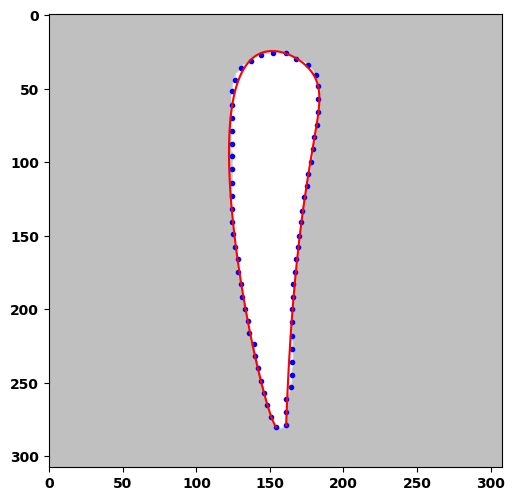

In [9]:
testOF(imgn=3,N=5,mode=1,err_th=1)

..
CP 5.0, steps:1, etime: 8.67188 err: 3.6063174974
...
CP 2.0, steps:4, etime: 12.29688 err: 1.9487501691
.................
CP 1.0, steps:21, etime: 32.84375 err: 0.9823981268
..............................................................................
....................................
CP 0.65, steps:135, etime: 171.25000 err: 0.6499256270
................................................................
....................................................................................................
.........................................................E

[] [array([], dtype=float64)]


(0.49996707160130355, array([], dtype=int64))

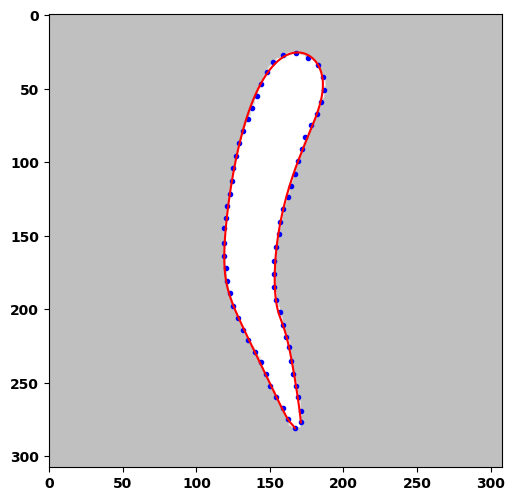

In [8]:
testOF(imgn=2,N=11,mode=1,err_th=0.5)

...............
CP 5.0, steps:14, etime: 10.26562 err: 4.9898051474
........................................................
CP 2.0, steps:70, etime: 37.76562 err: 1.9858640920
.............................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....^.........................................................................................^.....
..............^..........................................^^^.^................^.................E

[] [array([2.56502003, 2.39303048, 2.5667284 , 2.58490715, 2.17531283])]


(0.9998280552072191, array([], dtype=int64))

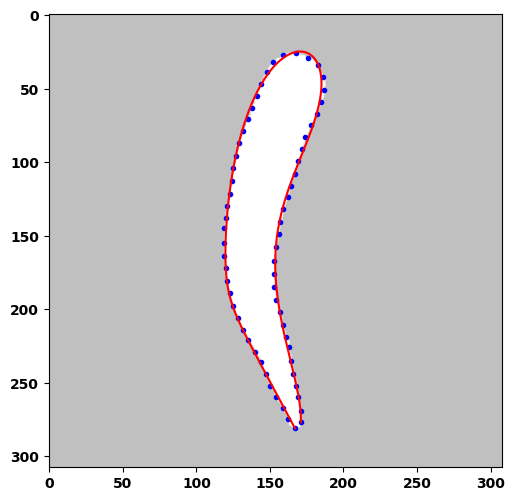

In [7]:
testOF(imgn=2,N=7,mode=1,err_th=1.0)

....
CP 5.0, steps:3, etime: 3.28125 err: 4.3044265142
...
CP 2.0, steps:6, etime: 4.39062 err: 1.8457861020
..........................................................................E

[] [array([2.56362791, 2.55849979, 3.1369641 ])]


(0.9997393514565017, array([], dtype=int64))

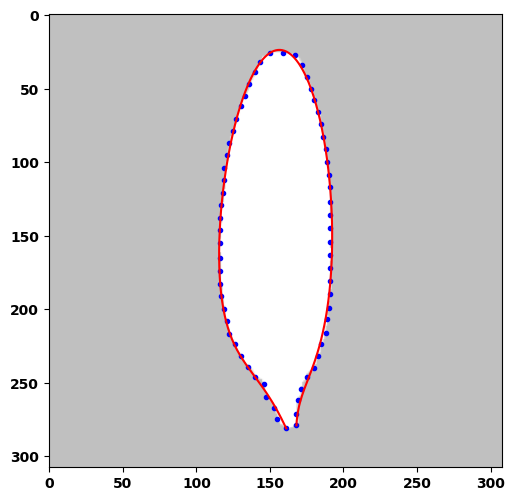

In [48]:
testOF(imgn=7,N=6,mode=1,err_th=1)

..............................................................................................
CP 5.0, steps:93, etime: 81.35938 err: 4.9965848423
......
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................
CP 2.0, steps:629, etime: 533.79688 err: 1.9918016908
......................................................................
..........................................................E

[] [array([4.03674788, 3.89402765, 2.31199772, 2.36127527, 2.326711  ,
       5.48981355])]


(0.9981112885317548, array([], dtype=int64))

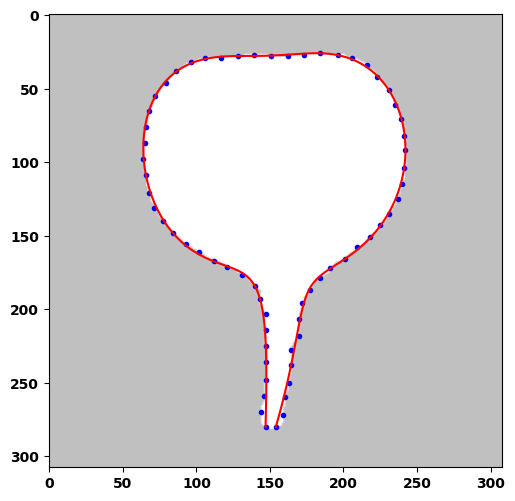

In [43]:
testOF(imgn=1,N=9,mode=1,err_th=1)

...................................................................................................
CP 5.0, steps:98, etime: 52.67188 err: 4.9694697422
.
...............................
CP 2.0, steps:130, etime: 68.81250 err: 1.9688029781
............................E

[] [array([1.70753352, 2.30762488, 2.80096123, 2.79890202])]


(0.9923874903686253, array([], dtype=int64))

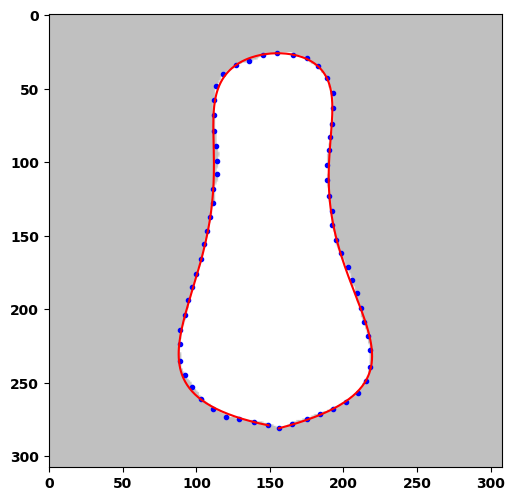

In [44]:
testOF(imgn=0,N=7,mode=1,err_th=1)

...................................................................................................
CP 5.0, steps:98, etime: 52.57812 err: 4.9694697422
.
...............................
CP 2.0, steps:130, etime: 68.82812 err: 1.9688029781
............................
CP 1.0, steps:158, etime: 83.35938 err: 0.9923874904
..............................E

[] [array([2.03449667])]


(0.6496268308769284, array([], dtype=int64))

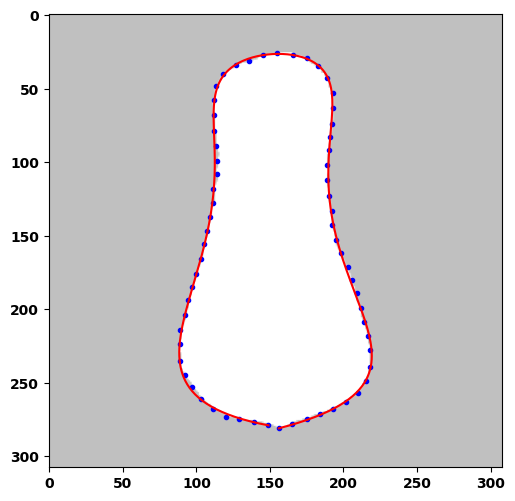

In [45]:
testOF(imgn=0,N=7,mode=1,err_th=0.65)

...................................................................................................
CP 5.0, steps:98, etime: 52.60938 err: 4.9694697422
.
...............................
CP 2.0, steps:130, etime: 68.85938 err: 1.9688029781
............................
CP 1.0, steps:158, etime: 83.07812 err: 0.9923874904
..............................
CP 0.65, steps:188, etime: 98.34375 err: 0.6496268309
...........
....................................................................................................
................................................................................^^^^^^^.^...........
............^^^^^^^^^^^^^^^^^^^^^^^.^^.^^.^^.^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^..^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.5137207747772943, array([], dtype=int64))

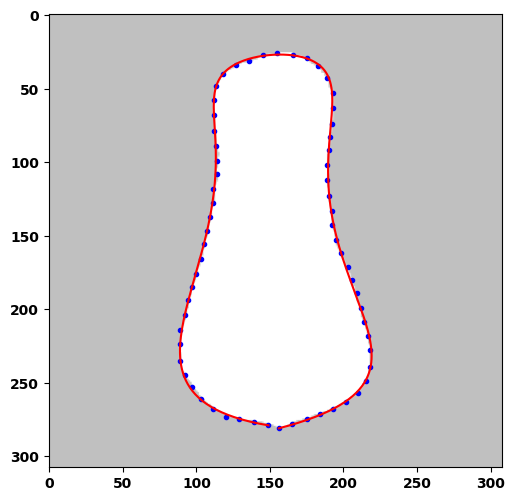

In [46]:
testOF(imgn=0,N=7,mode=1,err_th=0.5)

.....................................................................................
CP 5.0, steps:84, etime: 60.09375 err: 4.9085911684
...............
..........
CP 2.0, steps:109, etime: 76.84375 err: 1.9854089810
.....................
CP 1.0, steps:130, etime: 91.00000 err: 0.9817960167
..................
CP 0.65, steps:148, etime: 103.09375 err: 0.6443172570
.....................E

[] [array([1.83349963, 1.65517263])]


(0.4965834125046084, array([], dtype=int64))

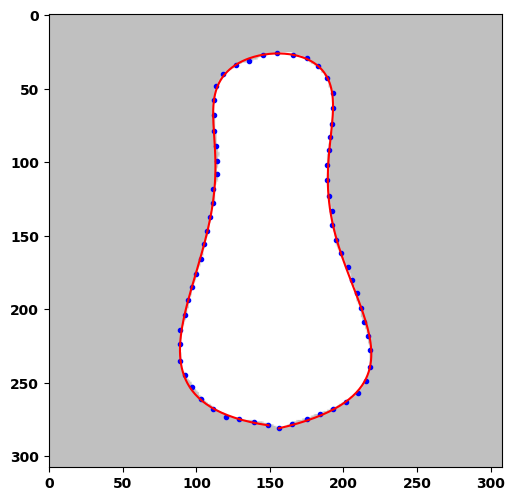

In [49]:
testOF(imgn=0,N=8,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 8.25000 err: 4.9053430804
........................................................................
CP 2.0, steps:75, etime: 81.82812 err: 1.9878677353
........................
..............................................................
CP 1.0, steps:161, etime: 169.54688 err: 0.9931436415
......................................
........................
CP 0.65, steps:223, etime: 233.18750 err: 0.6479230166
............................................................................
..............................................E

[] [array([1.82458897, 1.6452213 , 2.82140124, 2.34284038, 2.09274278])]


(0.49994577734864803, array([], dtype=int64))

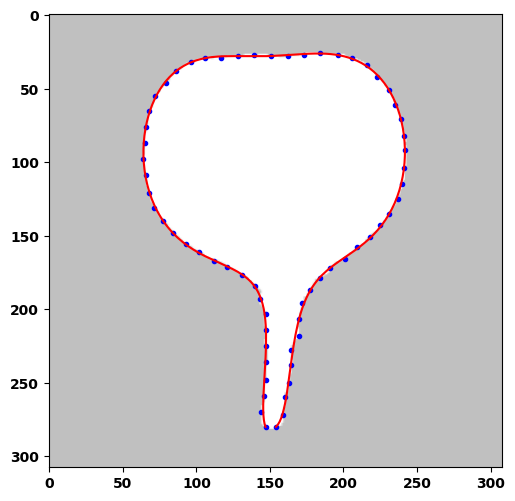

In [47]:
testOF(imgn=1,N=10,mode=1,err_th=0.5)

.
CP 5.0, steps:0, etime: 5.62500 err: 4.7731414878
...
CP 2.0, steps:3, etime: 9.29688 err: 1.9823850492
...............E

[] [array([2.21866942, 2.30912221])]


(0.9832486174480953, array([], dtype=int64))

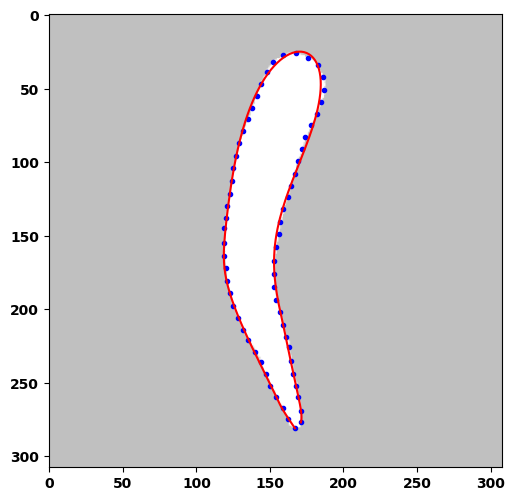

In [51]:
testOF(imgn=2,N=11,mode=1,err_th=1.0)

....
CP 5.0, steps:3, etime: 8.26562 err: 4.9053430804
........................................................................
CP 2.0, steps:75, etime: 81.09375 err: 1.9878677353
........................
..............................................................E

[] [array([2.70900909, 2.47640817, 2.78901931])]


(0.993143641451319, array([], dtype=int64))

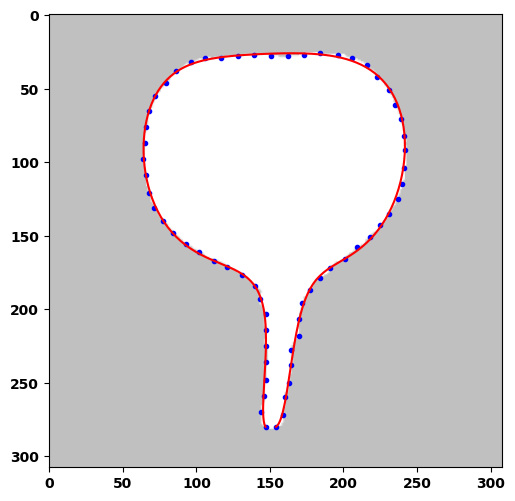

In [52]:
testOF(imgn=1,N=10,mode=1,err_th=1.0)